# Ensembling Feature Overview

This notebook provides an overview of the basic and advanced functionality of using ensemble methods in PySINDy. 

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

# define the Lorenz system
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

### Ensemble methods
One way to improve the robustness of a SINDy method is to use ensemble methods. Basically, we solve the regression problem many times on subsets (of size $n_{subset}$) of the time slices, generating $n_{models}$ models. All the coefficients are returned in model.coef_list and the average (bagging) can be used via np.mean(model.coef_list, axis=0) or the median (bragging) can be used via np.median(model.coef_list, axis=0). 

### The default number of models to generate is 20, and the default sampling strategy is to sample the entire time base with replacement, so that on average 60% or so of the data is seen. Default model is that the last fitted model is returned -- this is typically a bad approximation so use model.coef_list instead.

In [2]:
dt = .005
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
# add noise for more complexity
x_train = x_train + np.random.randn(x_train.shape[0], x_train.shape[1]) / 2.0

# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True)
model.print()
ensemble_coefs = model.coef_list

x' = -10.183 x + 9.979 y
y' = 0.217 1 + 24.802 x + -0.928 x z
z' = 1.679 1 + -0.280 x + -2.584 z + 0.948 x y


### Library ensemble methods
Another way to do ensembling is to solve the regression problem on subsets of the candidate library, generating $p$ (the number of candidate terms) models. The syntax and code is a bit different, but the user-facing part is the same. Once again, the coefficients are returned in model.coef_list and the average can be used via np.mean(model.coef_list, axis=0). The default is still 20 generated models and the default sub-sampling is to chop one candidate term for each model.

In [3]:
# Instantiate and fit the SINDy model
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True)
model.print()
library_ensemble_coefs = model.coef_list

x' = -0.197 1 + -9.835 x + 9.817 y
y' = 0.727 1 + 25.960 x + -0.354 y + -0.954 x z
z' = 0.307 1 + -0.138 x + 0.106 y + -2.660 z + 0.998 x y


### Now do both types of ensembling with multiple candidate drops!

In [4]:
double_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=double_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, ensemble=True, n_candidates_to_drop=2)
model.print()
double_ensemble_coefs = model.coef_list

x' = -1.515 1 + -9.958 x + 9.887 y
y' = -4.805 1 + 27.576 x + -0.802 y + 0.172 z + -0.972 x z
z' = -0.877 1 + 4.105 x + -0.983 y + -2.655 z + 0.987 x y + -0.109 x z


### Alternatives to averaging (bagging) or taking the median (bragging) of the models: 
1. Weighted average of the coefficients, with weights corresponding to the mean-squared error with the testing (or training, if you like) $\dot{\mathbf{X}}$.
2. Define a function that does small integration forward of all the potential models for a bunch of a random initial conditions and chop any unstable models. Then repeat bagging or bragging.

In [5]:
from sklearn.metrics import mean_squared_error

def weighted_coefficient_average(coef_list, x_test, dt, optimizer):
    mse = np.zeros(np.shape(coef_list)[0])
    for i in range(np.shape(coef_list)[0]):
        optimizer.coef_ = np.asarray(coef_list)[i, :, :]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
    avg = np.average(coef_list, axis=0, weights=mse)
    coef_subtracted = np.zeros(np.shape(coef_list))
    for i in range(np.shape(coef_list)[0]):
        coef_subtracted[i, :, :] = np.asarray(coef_list)[i, :, :] - avg
    std = np.sqrt(np.average(coef_subtracted ** 2, axis=0, weights=mse))
    return avg, std

e_wavg, e_wstd = weighted_coefficient_average(ensemble_coefs, x_test, dt, ensemble_optimizer)
l_wavg, l_wstd = weighted_coefficient_average(library_ensemble_coefs, x_test, dt, library_ensemble_optimizer) 

def integration_metric(coef_list, optimizer):
    t_test = np.arange(0, 2, 0.01)    
    # Try 5 test trajectories
    for k in range(5):
        x0_test = (np.random.rand(3) - 0.5) * 10
        x_test = odeint(lorenz, x0_test, t_test)  
        for i in range(np.shape(coef_list)[0]):
            optimizer.coef_ = coef_list[i, :, :]
            x_test_sim = model.simulate(x0_test, t_test)
            if np.any(np.abs(x_test_sim) > 100):
                print('unstable model!')
                coef_list[i, :, :] = 0.0
    return coef_list

stable_ensemble_coefs = integration_metric(np.asarray(ensemble_coefs), ensemble_optimizer)
stable_library_ensemble_coefs = integration_metric(np.asarray(library_ensemble_coefs), library_ensemble_optimizer)

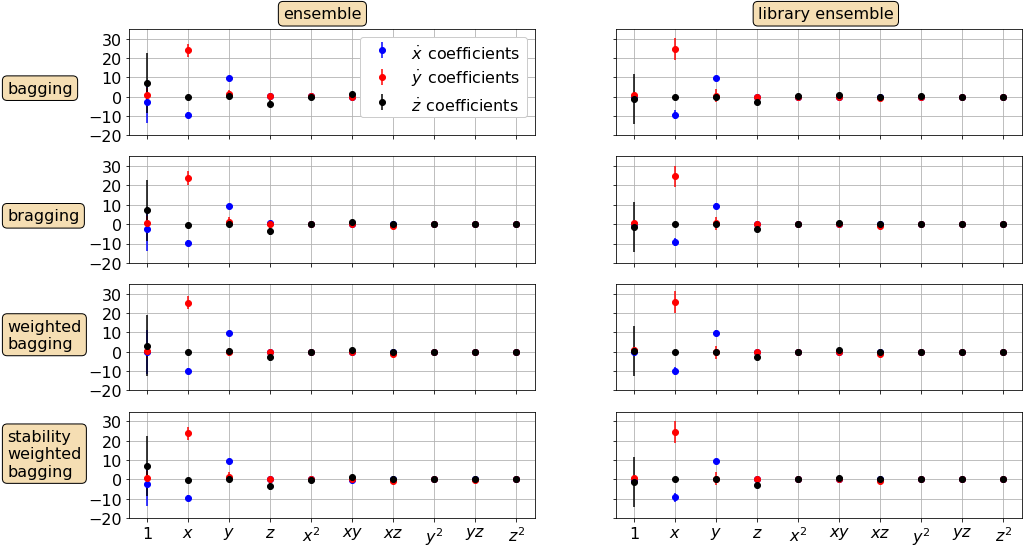

In [6]:
# Plot bagging results with error bars
coef_types = [np.mean(ensemble_coefs, axis=0), 
              np.mean(library_ensemble_coefs, axis=0), 
              e_wavg,
              l_wavg,
              np.median(ensemble_coefs, axis=0),
              np.median(library_ensemble_coefs, axis=0),
              np.mean(stable_ensemble_coefs, axis=0), 
              np.mean(stable_library_ensemble_coefs, axis=0), 
             ]
coef_stds = [np.std(ensemble_coefs, axis=0), 
             np.std(library_ensemble_coefs, axis=0), 
             e_wstd,
             l_wstd,
             np.std(ensemble_coefs, axis=0), 
             np.std(library_ensemble_coefs, axis=0), 
             np.std(stable_ensemble_coefs, axis=0), 
             np.std(stable_library_ensemble_coefs, axis=0), 
             ]
colors = ['b', 'r', 'k']
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
textstrs = ['bagging', 'bragging', 'weighted\nbagging', 'stability\nweighted\nbagging']
plt.figure(figsize=(16, 9))
for k, coefs in enumerate(coef_types):
    coef_std = coef_stds[k]
    plt.subplot(4, 2, k + 1)
    for i in range(coefs.shape[0]):
        plt.errorbar(range(coefs.shape[1]), coefs[i, :], yerr=coef_std[i, :], 
                     fmt='o', color=colors[i], label='$\dot ' + feature_names[i] + '_{}$' + ' coefficients')
    ax = plt.gca()
    ax.set_xticks(range(10))
    if k >= 6:
        xticknames = model.get_feature_names()
        for i in range(10):
            xticknames[i] = '$' + xticknames[i] + '$'
        ax.set_xticklabels(xticknames, verticalalignment='top')
    else:
        ax.set_xticklabels([])
    plt.ylim(-20, 35)
    if k == 0:
        plt.legend(fontsize=16, framealpha=1.0, loc='upper right')
        ax.text(0.38, 1.1, 'ensemble', transform=ax.transAxes, fontsize=16, bbox=props)
    if k == 1:
        ax.text(0.35, 1.1, 'library ensemble', transform=ax.transAxes, fontsize=16, bbox=props)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    ax.set_yticks([-20, -10, 0, 10, 20, 30])
    if k % 2 == 0:
        textstr = textstrs[k // 2]
        ax.text(-0.3, 0.4, textstr, transform=ax.transAxes, fontsize=16, bbox=props)
    else:
        ax.set_yticklabels([])
plt.savefig('ensemble_summary.pdf')

### Repeat ensembling but now make ~1000 models and plot the distributions of coefficients

In [27]:
# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, n_models=1000)
model.print()
ensemble_coefs = np.asarray(model.coef_list)

x' = 2.298 1 + -9.996 x + 9.896 y + -0.146 z
y' = -8.181 1 + 23.828 x + 0.381 z + -0.104 x^2 + 0.126 x y + -0.903 x z
z' = 9.382 1 + -0.610 x + 0.170 y + -2.942 z + 0.987 x y


In [28]:
# Instantiate and fit the SINDy model
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, n_models=1000)
model.print()
library_ensemble_coefs = np.asarray(model.coef_list)

x' = -0.197 1 + -9.835 x + 9.817 y
y' = 0.727 1 + 25.960 x + -0.354 y + -0.954 x y
z' = 7.721 1 + 0.950 x + -0.452 y + -3.431 z + 0.523 x^2 + 0.476 x z


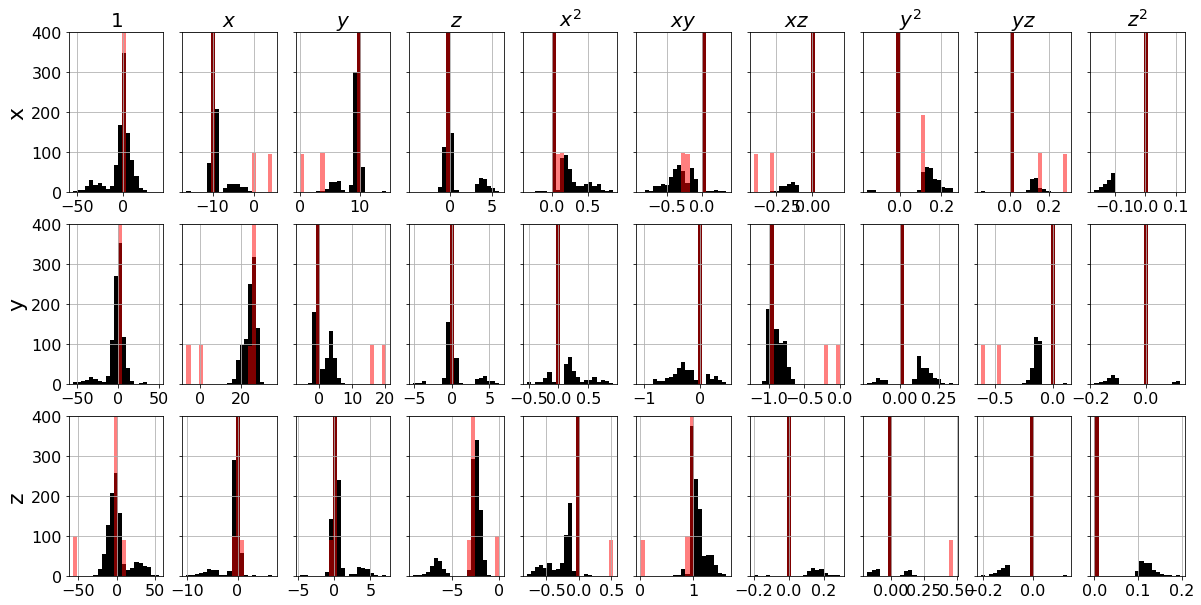

In [55]:
plt.figure(figsize=(20, 10))
for i in range(10):
    for j in range(3):

        plt.subplot(3, 10, j * 10 + 1 + i)
        if j == 0:
            plt.title(xticknames[i], fontsize=20)
        min_bins = min(np.min(ensemble_coefs[:, j, i]), np.min(library_ensemble_coefs[:, j, i]))
        max_bins = max(np.max(ensemble_coefs[:, j, i]), np.max(library_ensemble_coefs[:, j, i]))
        bins = np.linspace(min_bins, max_bins, 22)
        plt.hist(ensemble_coefs[:, j, i], color='k', bins=bins) #, label=feature_names[j] + "' : " + xticknames[i])
        plt.hist(library_ensemble_coefs[:, j, i], bins=bins, color='r', alpha=0.5) #, label=feature_names[j] + "' : " + xticknames[i])
        plt.grid(True)
        ax = plt.gca()
        if i == 0:
            plt.ylabel(feature_names[j], fontsize=22)
        else:
            ax.set_yticklabels([])
        plt.ylim(0, 400)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)